In [1]:
%load_ext autoreload
import race
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
%matplotlib inline
%reload_ext autoreload

pygame 2.5.2 (SDL 2.28.3, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from stable_baselines3.common.env_checker import check_env
import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [3]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [4]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [5]:
def evaluate_model(model, env, num_episodes=100):  
    
    total_reward = 0.0
    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done,info, _ = env.step(action)
            total_reward += reward
    mean_reward = total_reward / num_episodes
    return mean_reward

In [6]:
from stable_baselines3 import A2C, PPO, TD3, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

def objective(trial: optuna.Trial) -> float:   
    hyperparams = {
        "neg_reward_small": trial.suggest_int("neg_reward_small", -10, -1),
        "neg_reward_big": trial.suggest_int("neg_reward_big", -50, -10),
        "pos_reward_factor": trial.suggest_int("pos_reward_factor", 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'buffer_size': trial.suggest_int('buffer_size', 1000, 100000),
        'gamma': trial.suggest_float('gamma', 0.9, 0.999),
        'tau': trial.suggest_float('tau', 1e-3, 1e-1, log=True)   
    }
    # Define the environment
    env = gymnasium.make('CurvyRaceEnv-v0', pos_reward_factor=hyperparams["pos_reward_factor"],neg_reward_small=hyperparams["neg_reward_small"],neg_reward_big=hyperparams["neg_reward_big"])  
    


    
    
    

    # Create and train the DDPG model
    model = DDPG('MlpPolicy', env, learning_rate=hyperparams['learning_rate'], buffer_size=hyperparams['buffer_size'],
                 gamma=hyperparams['gamma'], tau=hyperparams['tau'],
                 action_noise=NormalActionNoise(mean=np.zeros(env.action_space.shape), sigma=0.1 * np.ones(env.action_space.shape)))
    
    # Train the model
    model.learn(total_timesteps=10000)  # Adjust the total_timesteps as needed

    # Evaluate the model
    mean_reward = evaluate_model(model, env)

    return mean_reward

In [7]:
#study = optuna.create_study(study_name="DDPG", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

In [8]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")
env = Monitor(env, "logs/ddpg")
model_ddpg = DDPG("MlpPolicy", env,  learning_rate=0.004859847958257243,tau=0.06431401009446525,  gamma = 0.9703705891833702, buffer_size=82149)
model_ddpg.learn(total_timesteps=2000)
model_ddpg.save("models/model_ddpg")
_, _ = env.reset()
del model_ddpg

#env = Monitor(env, "logs/td3")
#model_td3 = TD3("MlpPolicy", env,  learning_rate=2e-3,policy_kwargs=dict(net_arch=[400,300]), learning_starts=5000,gradient_steps=-1, gamma = 0.9, buffer_size=200000)
#model_td3.learn(total_timesteps=25000)
#model_td3.save("models/model_td3")
#_, _ = env.reset()
#del model_td3

#env = Monitor(env, "logs/sac")
#model_sac = SAC("MlpPolicy", env, verbose=1, batch_size=64, learning_rate=2e-3, gamma=0.9, tau=0.05)
#model_sac.learn(total_timesteps=25000)
#model_sac.save("models/model_sac")
#_, _ = env.reset()
#del model_sac

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


In [9]:
env.close()

In [10]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    observation_list = []
    while not done:
        action, _states = model.predict(obs)
        print(action)
        obs, rewards, done, info, _ = env.step(action)
        observation_list.append(obs)
        reward_list.append(rewards)
    env.render()
    return reward_list

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


In [12]:
import pandas as pd
def load_log(path):
    data =  pd.read_csv(path, index_col=None).index.tolist()[1:]    
    return [float(x) for x in data]

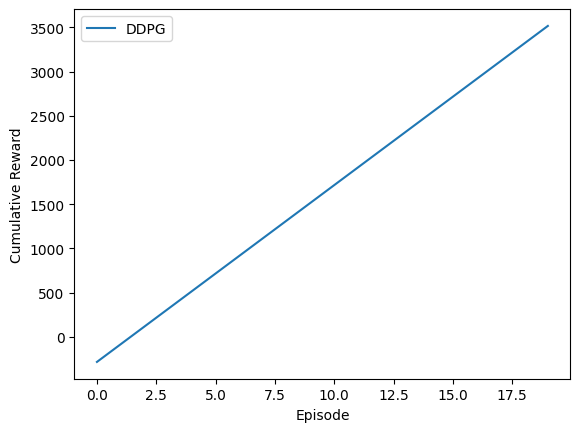

In [13]:
from stable_baselines3 import DDPG,SAC, TD3
ddpg = DDPG.load("models/model_ddpg.zip")
#sac = SAC.load("models/model_sac.zip")
#td3 = TD3.load("models/model_td3.zip")

test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
rewards["DDPG"] = load_log("logs/ddpg.monitor.csv")
#rewards["sac"] = load_log("logs/sac.monitor.csv")
#rewards["td3"] = load_log("logs/td3.monitor.csv")



plot_cumulative_rewards(rewards)

C:\Studium\MasterStudium\DRL\Studienarbeiten\Studienarbeit2\DRL_Studienarbeit2_env\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]
[-4. -2.]


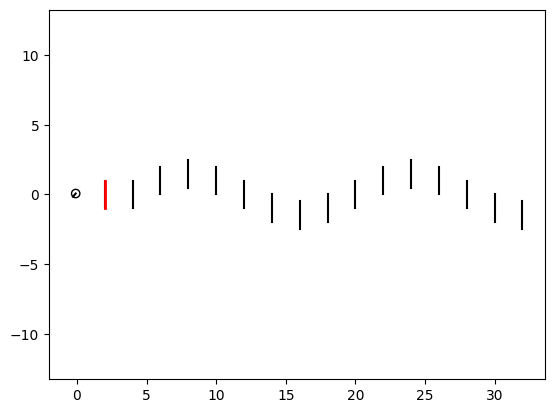

[-2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.9633773027803185,
 -2.963377

In [14]:
run_env(test, ddpg)

In [15]:
test.action_space

Box([-4. -2.], [4. 2.], (2,), float64)